In [ ]:
import os
from config import *
from data_acquisition import *
from richdem import TerrainAttribute, LoadGDAL
from skimage.transform import resize
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor


ndvi_path = "outputs/output_s2_2024-05-10_2024-05-12.tif"                                       # Sentinel-2 NDVI (alta resolución)
dem_path = "/home/tidop/Downloads/AP_07598_FBD_F0800_RT1/AP_07598_FBD_F0800_RT1.dem.tif"        # Elevación ALOS PALSAR 12.5m
lst_path = "outputs/output_s3_2024-05-04_2024-05-06.tif"                                        # LST Sentinel-3 rasterizado (baja resolución)

dem_clip_path = "outputs/output_dem_clip.tif"

get_dem(os.path.join(GEOJSON_DIR, "networks.geojson"), dem_path, dem_clip_path, row=2)

In [19]:
# 1. Leer datos
ndvi = rio.open(ndvi_path).read(1)          # Sentinel-2 NDVI (alta resolución)
dem = dem_clip_path                         # Elevación ALOS PALSAR 12.5m
lst = rio.open(lst_path).read(1)            # LST Sentinel-3 rasterizado (baja resolución)

# 2. Derivar slope, aspect (opcional)
dem_rd = LoadGDAL(dem)
slope = TerrainAttribute(dem_rd, attrib='slope_degrees')
aspect = TerrainAttribute(dem_rd, attrib='aspect')
curvature = TerrainAttribute(dem_rd, attrib='curvature')  # Puede actuar como un proxy de TPI


A Slope calculation (degrees)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.274387======================= ] (99% - 0.0s - 1 threads)

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.191646======================= ] (99% - 0.0s - 1 threads)

A Curvature attribute calculation
C Zevenbergen, L.W., Thorne, C.R., 1987. Quantitative analysis of land surface topography. Earth surface processes and landforms 12, 47–56.

t Wall-time = 0.0323129====================== ] (99% - 0.0s - 1 threads)===== ] (98% - 0.0s - 1 threads)


In [26]:
ndvi.shape

(2534, 2289)

In [20]:
# 3. Reescalar variables a alta resolución (interpolación)
dem_array = rio.open(dem_clip_path).read(1)

dem_rescaled = resize(dem_array, ndvi.shape, order=1)
slope_rescaled = resize(slope, ndvi.shape, order=1)
aspect_rescaled = resize(aspect, ndvi.shape, order=1)
curvature_rescaled = resize(curvature, ndvi.shape, order=1)
lst_upsampled = resize(lst, ndvi.shape, order=1)

In [21]:
# Ahora stack sin errores
X = np.stack([ndvi.flatten(), dem_rescaled.flatten(), slope_rescaled.flatten(), curvature_rescaled.flatten()], axis=1)
y = lst_upsampled.flatten()

In [22]:
# Ya tienes esta máscara de NaN
mask = ~np.isnan(y) & ~np.isnan(X).any(axis=1)

# Ahora agrega una condición para valores finitos
mask &= np.isfinite(X).all(axis=1) & np.isfinite(y)

# 2. Filtrar datos válidos
X_clean = X[mask]
y_clean = y[mask]

# Submuestreo aleatorio si hay muchos datos
max_samples = 2_000_000
if len(X_clean) > max_samples:
    X_clean, y_clean = shuffle(X_clean, y_clean, random_state=42)
    X_clean = X_clean[:max_samples]
    y_clean = y_clean[:max_samples]

In [23]:
# 3. Entrenar modelo
model = RandomForestRegressor(n_estimators=30, max_depth=20, n_jobs=-1)
model.fit(X_clean, y_clean)

# 4. Predecir sobre todos los píxeles válidos
y_pred = model.predict(X_clean)

# 5. Crear raster de predicción completo, llenando solo donde hay datos válidos
lst_10m = np.full(ndvi.shape, np.nan)
lst_10m.flat[mask] = y_pred

In [24]:
# Comparación solo sobre datos usados para entrenar
print("R² score:", r2_score(y_clean, y_pred))
print("RMSE:", mean_squared_error(y_clean, y_pred, squared=False))

R² score: 0.30468439894111465
RMSE: 4.383221612957134


/home/tidop/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


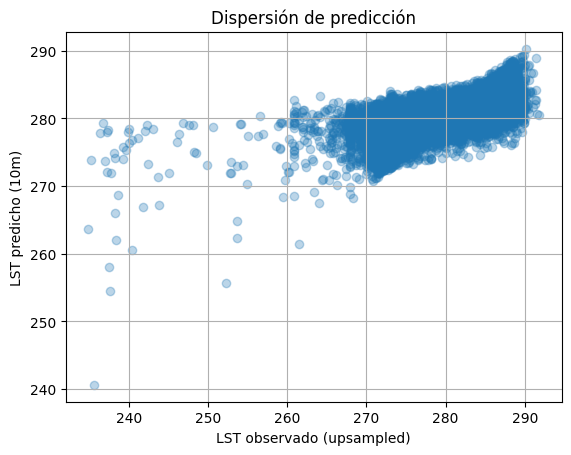

In [25]:
import matplotlib.pyplot as plt

plt.scatter(y_clean[:30000], y_pred[:30000], alpha=0.3)
plt.xlabel("LST observado (upsampled)")
plt.ylabel("LST predicho (10m)")
plt.title("Dispersión de predicción")
plt.grid()
plt.show()